# Libraries

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

import spacy
nlp = spacy.load('pl_core_news_sm')

from preprocessing_modules.process_raw_data import download_and_extract_zip, read_text_files_into_dataframe
from preprocessing_modules.plot_data import update_seaborn_plot_labels_title, plot_ngram
from preprocessing_modules.preprocess_data import encoded_special_signs, clean_text, is_token_allowed, preprocess_token

# Import and process raw data

In [2]:
# Specify URLs with data
urls = ["http://2019.poleval.pl/task6/task_6-1.zip", "http://2019.poleval.pl/task6/task6_test.zip"]

# Replace the 'extract_path' with the folder where you want to extract the contents
extract_path = './data_raw/'

# Call the function to download and extract the zip file with training data
download_and_extract_zip(urls[0], extract_path)

# Call the function to download and extract the zip file with test data
download_and_extract_zip(urls[1], extract_path, specific_folder='Task6/task 01')

Extraction of http://2019.poleval.pl/task6/task_6-1.zip completed successfully.
Extraction of http://2019.poleval.pl/task6/task6_test.zip completed successfully.


In [4]:
# Create dataframe with text data
df = read_text_files_into_dataframe("data_raw")

# Get train and test data
train, test = df.loc[df.split == 'train', ['text', 'label']], df.loc[df.split == 'test', ['text', 'label']]
train, test = train[train.label.isna()==False], test[test.label.isna()==False]

In [5]:
# Check if data is balanced
train.label.value_counts()

label
0    9190
1     851
Name: count, dtype: int64

[ENG]: The dataset is clearly unbalanced and most tweets are marked as harmless. This fact should be kept in mind when further exploring the text data, so as not to draw false conclusions about the existence of some important class-distinguishing variables. 

[PL]: Zbiór danych jest wyraźnie niezrównoważony i większość tweetów jest oznaczona jako nieszkodliwe. Fakt ten należy mieć na uwadze podczas dalszej eksploracji danych tekstowych, aby nie wyciągnąć nieprawdziwych wniosków dotyczących istnienia pewnych istotnych zmiennych rozróżniających klasy. 

# Prepare data for classification

In [6]:
# Prepare training and test data
train['text_no_emoji'] = train.text.apply(lambda row: clean_text(row, punctuation=False))
train['text_preprocessed'] = train.text_no_emoji.apply(lambda row: [preprocess_token(token) for token in nlp(row) if is_token_allowed(token)])
train.to_csv("./data/train.csv", index=False)

test['text_no_emoji'] = test.text.apply(lambda row: clean_text(row, punctuation=False))
test['text_preprocessed'] = test.text_no_emoji.apply(lambda row: [preprocess_token(token) for token in nlp(row) if is_token_allowed(token)])
test.to_csv("./data/test.csv", index=False)

# Data exploration

## Length of unprocessed text

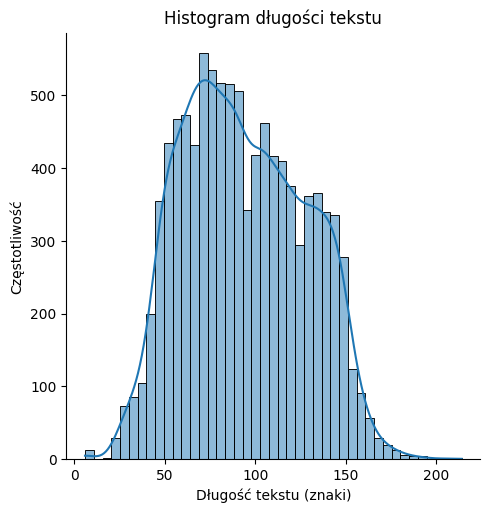

In [9]:
train['length'] = train.text.apply(lambda row: len(row))
plot = sns.displot(train.length, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (znaki)', ylabel='Częstotliwość', title='Histogram długości tekstu')
plt.show()

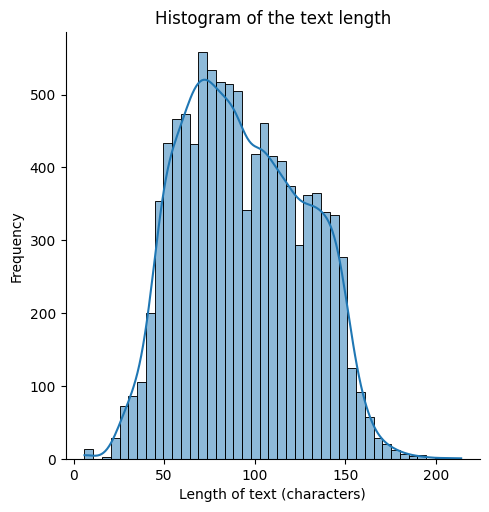

In [10]:
""" ENG """
plot = sns.displot(train.length, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Length of text (characters)', ylabel='Frequency', title='Histogram of the text length')
plt.show()

[ENG]: The chart shows the distribution of tweet lengths considering the number of characters. The longest tweets reach a length of more than 150 characters, and the shortest to about 50. On average, tweets are in the range of 80-100 characters. 

[PL]: Wykres prezentuje rozkład długości tweetów uwzględniając liczbę znaków. Najdłuższe tweety osiągają długość ponad 150 znaków, a najkrótsze do około 50. Przeciętnie tweety mieszczą się w przedziale 80-100 znaków. 

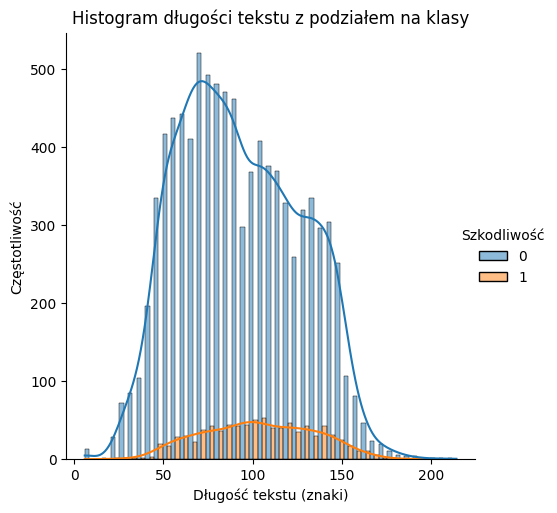

In [11]:
plot = sns.displot(data=train, x='length', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (znaki)', ylabel='Częstotliwość', title='Histogram długości tekstu z podziałem na klasy', legend='Szkodliwość')
plt.show()

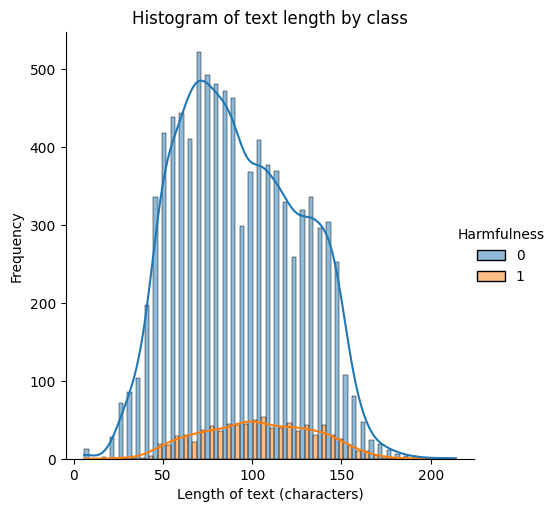

In [12]:
""" ENG """
plot = sns.displot(data=train, x='length', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Length of text (characters)', ylabel='Frequency', title='Histogram of text length by class', legend='Harmfulness')
plt.show()

[ENG]: The chart shows the distribution of tweet lengths considering the number of characters by tweet class. Harmful tweets are relatively longer than harmless tweets. Moreover, the distribution of harmless tweets is less spread out, while harmful tweets resemble a uniform distribution over the 80-130 character range. 

[PL]: Wykres prezentuje rozkład długości tweetów uwzględniając liczbę znaków z podziałem na klasę tweetu. Tweety szkodliwe są względnie dłuższe aniżeli tweety nieszkodliwe. Co więcej, rozkład tweetów nieszkodliwych jest mniej rozłożysty, natomiast tweetów szkodliwych przypomina rozkład jednostajny na przedziale 80-130 znaków. 

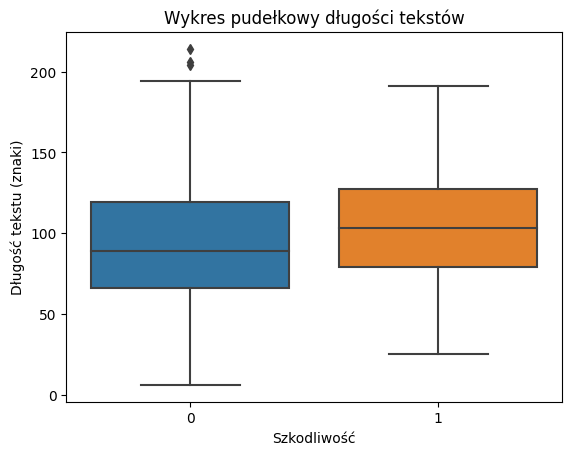

In [8]:
plot = sns.boxplot(y='length', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Długość tekstu (znaki)', title='Wykres pudełkowy długości tekstów')
plt.show()

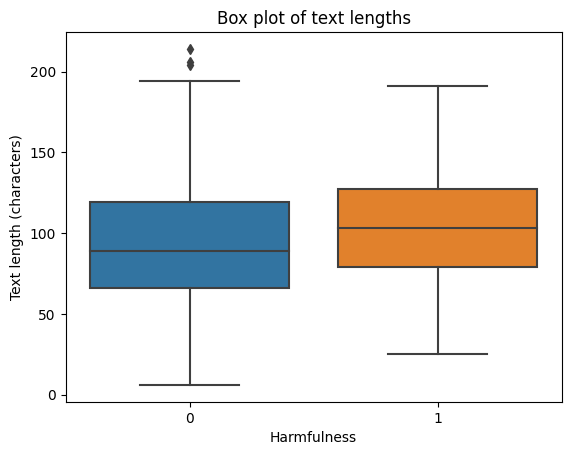

In [13]:
""" ENG """
plot = sns.boxplot(y='length', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Harmfulness', ylabel='Text length (characters)', title='Box plot of text lengths')
plt.show()

[ENG]: A box plot of tweet lengths by harm class shows the previous conclusion. Harmless tweets are shorter on average. In addition, outlier observations can be seen among them. Harmful tweets, on the other hand, are characterized by greater regularity and no excessive jumps in text length.

[PL]: Wykres pudełkowy długości tweetów z podziałem na klasę szkodliwości ukazuje poprzedni wniosek. Tweety nieszkodliwe są średnio krótsze. Ponadto można wśród nich zauważyć obserwacje odstające. Natomiast tweety szkodliwe cechuje większa regularność i brak nadmiernych skoków w długości tekstu.

## Amount of mentions in tweets

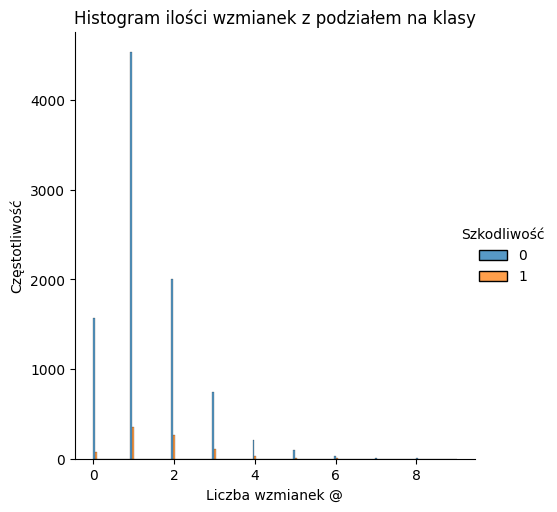

In [39]:
train['n_of_mentions'] = train.text.str.count("@anonymized_account")
plot = sns.displot(data=train, x='n_of_mentions', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Liczba wzmianek @', ylabel='Częstotliwość', title='Histogram ilości wzmianek z podziałem na klasy', legend='Szkodliwość')
plt.show()

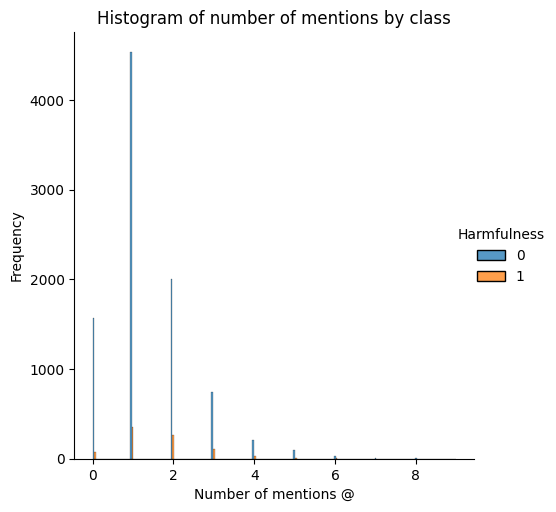

In [14]:
""" ENG """
plot = sns.displot(data=train, x='n_of_mentions', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Number of mentions @', ylabel='Frequency', title='Histogram of number of mentions by class', legend='Harmfulness')
plt.show()

[ENG]: The graph of the frequency of mentions in tweets does not show any specific property. Seemingly innocuous tweets contain more of them, but this is due to unbalanced classes. Taking this into account, both types of texts mostly contain between 0 and 3 mentions. There are also outlier observations.

[PL]: Wykres częstości występowania wzmianek w tweetach nie wykazuje żadnej konkretnej właściwości. Z pozoru tweety nieszkodliwe zawierają ich więcej, ale wynika to z niezrównoważenia klas. Uwzględniając ten fakt, obydwa rodzaje tekstów zawierają przeważnie od 0 do 3 wzmianek. Występują także obserwacje odstające.

## Amount of emojis in tweets

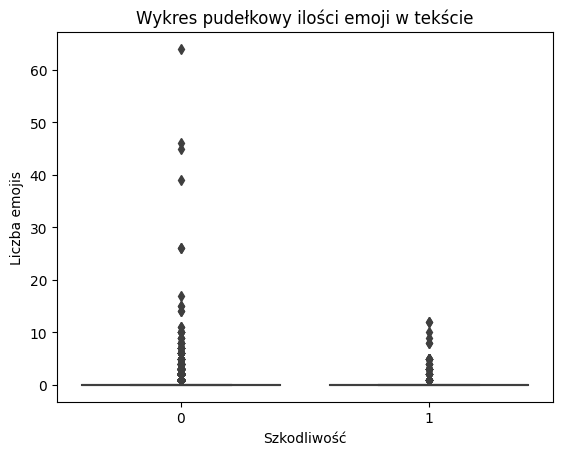

In [15]:
train['emojis'] = train.text.apply(lambda row: encoded_special_signs(row))
plot = sns.boxplot(y='emojis', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Liczba emojis', title='Wykres pudełkowy ilości emoji w tekście')
plt.show()

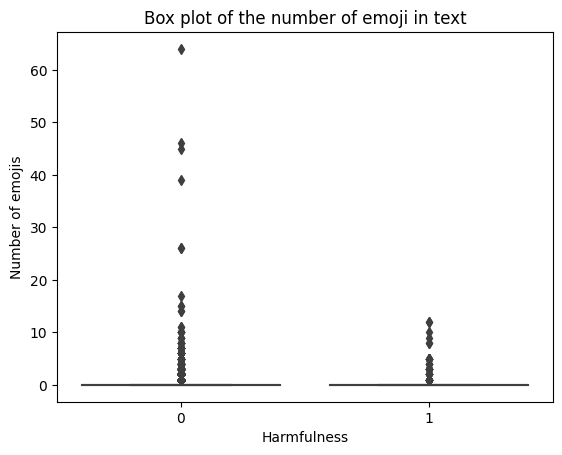

In [16]:
""" ENG """
plot = sns.boxplot(y='emojis', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Harmfulness', ylabel='Number of emojis', title='Box plot of the number of emoji in text')
plt.show()

[ENG]: A box plot of the number of mentions in the texts confirms earlier conclusions. Moreover, it highlights the number of outlier observations in both classes.

[PL]: Wykres pudełkowy ilości wzmianek w tekstach potwierdza wcześniejsze wnioski. Co więcej, uwidocznia ilość obserwacji odstających w obydwu klasach.

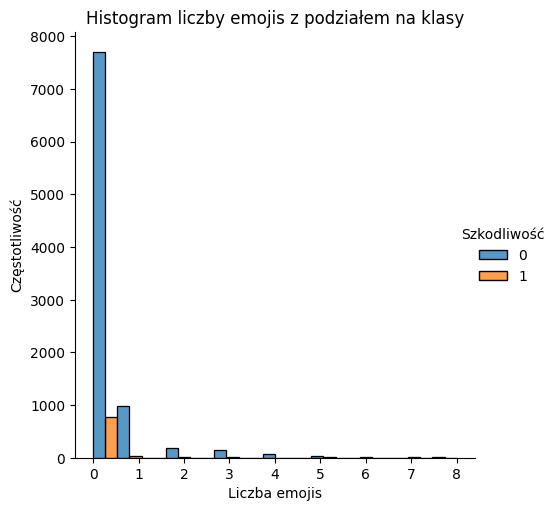

In [38]:
plot = sns.displot(data=train[train.emojis <= 8], x='emojis', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Liczba emojis', ylabel='Częstotliwość', title='Histogram liczby emojis z podziałem na klasy', legend='Szkodliwość')
plt.show()

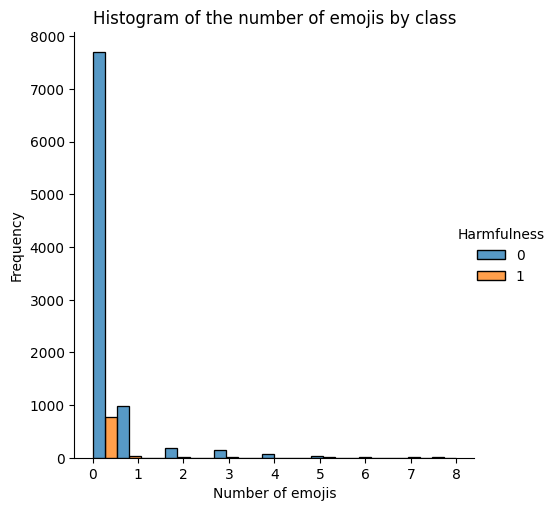

In [17]:
""" ENG """
plot = sns.displot(data=train[train.emojis <= 8], x='emojis', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Number of emojis', ylabel='Frequency', title='Histogram of the number of emojis by class', legend='Harmfulness')
plt.show()

[ENG]: A graph of the frequency of emoji icons in texts reveals a potentially important feature. In harmless tweets, emoticons occur more frequently and in greater numbers. In contrast, for harmful tweets, emoji emoticons are mostly absent.

[PL]: Wykres częstości występowania ikonek emoji w tekstach ukazuje pewną potencjalnie istotną cechę. W przypadku tweetów nieszkodliwych emotikony występują częściej oraz w większych ilościach. Z kolei dla tweetów szkodliwych emotikony emoji przeważnie nie występują.

## Length of tweets based on words

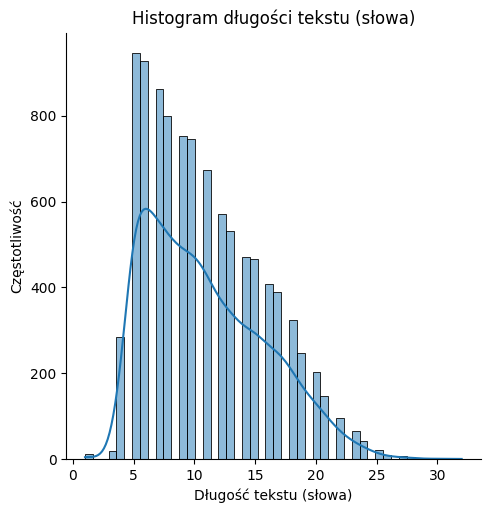

In [19]:
train['text_cleaned'] = train.text.apply(lambda row: clean_text(row))
train['word_length_cleaned'] = train.text_cleaned.apply(lambda row: len(row.split()))
plot = sns.displot(train.word_length_cleaned, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (słowa)', ylabel='Częstotliwość', title='Histogram długości tekstu (słowa)')
plt.show()

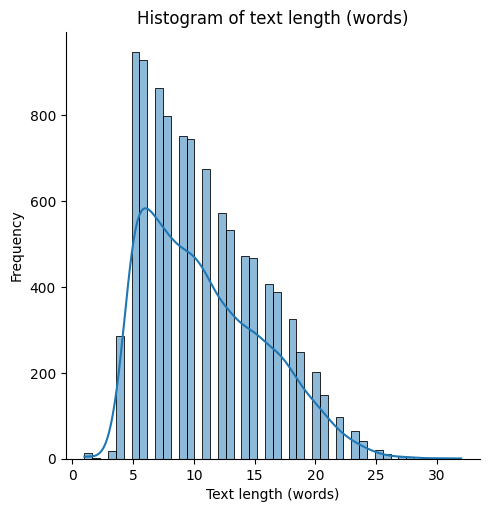

In [20]:
""" ENG """
plot = sns.displot(train.word_length_cleaned, kde=True)
update_seaborn_plot_labels_title(plot, xlabel='Text length (words)', ylabel='Frequency', title='Histogram of text length (words)')
plt.show()

[ENG]: The graph shows the frequency of text length per unit of words. The maximum tweets are between 20 and 30 words, and the minimum is 5. In contrast, most tweets are between 5 and 12 words. 

[PL]: Wykres przedstawia częstość długości tekstu w jednostce słów. Maksymalnie tweety zawierają od 20 do 30 słów, a minimalnie do 5. Z kolei większość tweetów mieści się w przedziale od 5 do 12 słów. 

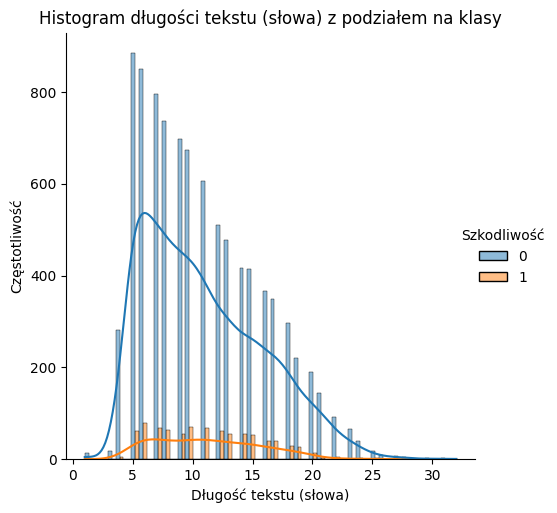

In [13]:
plot = sns.displot(data=train, x='word_length_cleaned', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Długość tekstu (słowa)', ylabel='Częstotliwość', title='Histogram długości tekstu (słowa) z podziałem na klasy', legend='Szkodliwość')
plt.show()

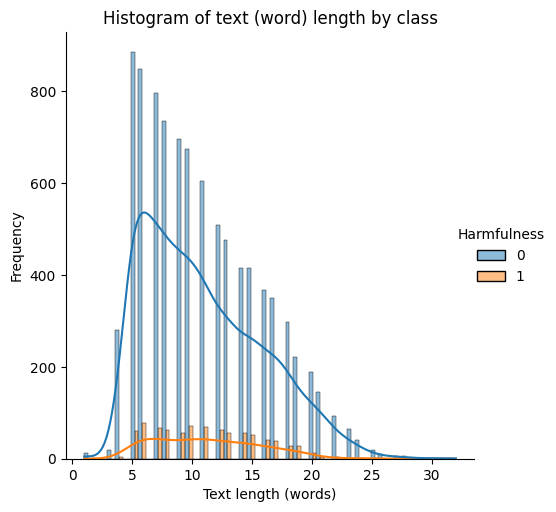

In [21]:
""" ENG """
plot = sns.displot(data=train, x='word_length_cleaned', kde=True, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Text length (words)', ylabel='Frequency', title='Histogram of text (word) length by class', legend='Harmfulness')
plt.show()

[ENG]: A histogram of text length based on words by class manifests a similar conclusion to a histogram of text length based on characters. Non-harmful tweets are generally shorter between 5 and 10 words. Harmful tweets, on the other hand, resemble a uniform distribution, and their length is mostly between 5 and 15 words.

[PL]: Histogram długości tekstu bazując na słowach z podziałem na klasy przejawia podobny wniosek co histogram długości tekstu oparty na znakach. Tweety  nieszkodliwe są z reguły krótsze od 5 do 10 słów. Z kolei tweety szkodliwe przypominają rozkład jednostajny, i ich długość w większości znajduje się w przedziale od 5 do 15 słów.

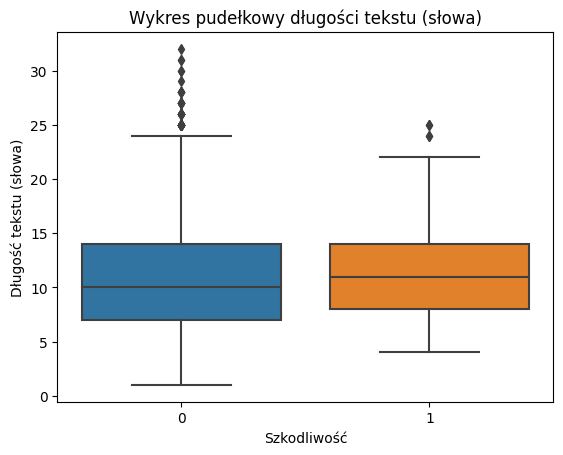

In [14]:
plot = sns.boxplot(y='word_length_cleaned', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Długość tekstu (słowa)', title='Wykres pudełkowy długości tekstu (słowa)')
plt.show()

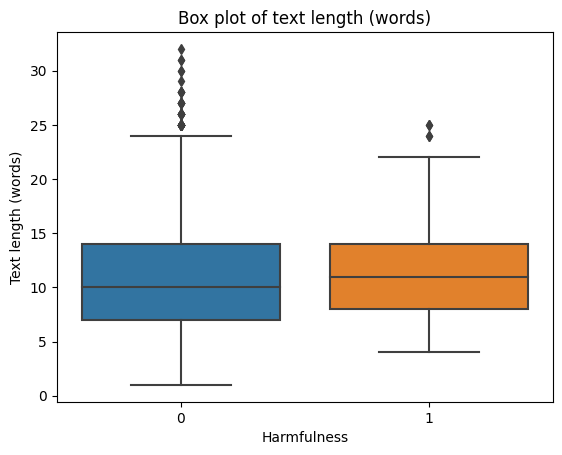

In [22]:
""" ENG """
plot = sns.boxplot(y='word_length_cleaned', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Harmfulness', ylabel='Text length (words)', title='Box plot of text length (words)')
plt.show()

[ENG]: The box plot confirms the earlier conclusion obtained from the histogram. Harmful tweets on average have a higher word count than harmless tweets. In both cases, however, there are exceptions in the form of outlier observations. 

[PL]: Wykres pudełkowy potwierdza wcześniejszy wniosek uzyskany na podstawie histogramu. Tweety szkodliwe średnio posiadają większą ilość słów, aniżeli tweety nieszkodliwe. W obydwu przypadkach występują jednak wyjątki w postaci obserwacji odstających. 

## Amount of retweets

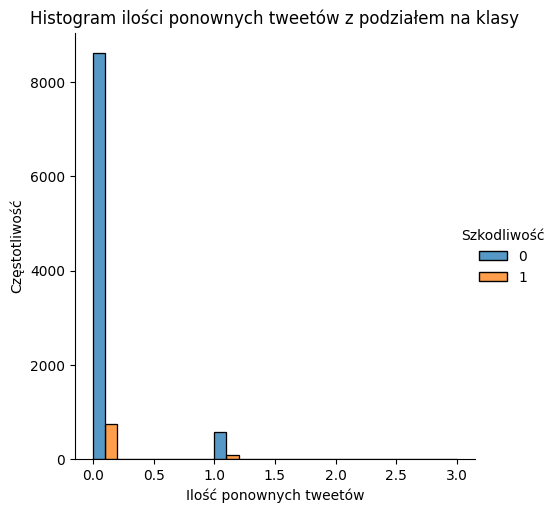

In [23]:
train['n_of_retweets'] = train.text_preprocessed.apply(lambda row: sum([t == 'rt' for t in row]))
plot = sns.displot(data=train, x='n_of_retweets', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Ilość ponownych tweetów', ylabel='Częstotliwość', title='Histogram ilości ponownych tweetów z podziałem na klasy', legend='Szkodliwość')
plt.show()

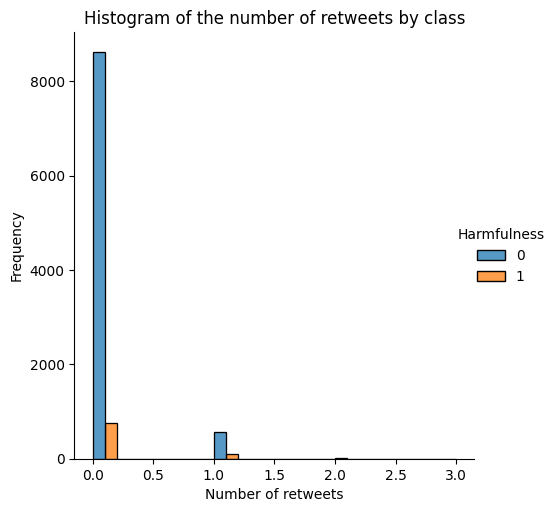

In [24]:
""" ENG """
plot = sns.displot(data=train, x='n_of_retweets', kde=False, hue='label', multiple='dodge')
update_seaborn_plot_labels_title(plot, xlabel='Number of retweets', ylabel='Frequency', title='Histogram of the number of retweets by class', legend='Harmfulness')
plt.show()

[ENG]: A histogram of the number of retweets by class does not imply specific conclusions. Both classes contain retweets with a natural majority proportion of harmless tweets resulting from an unbalanced dataset. 

[PL]: Histogram ilości ponownych tweetów z podziałem na klasy nie implikuje konkretnych wniosków. Obydwie klasy zawierają retweety z naturalną proporcją większościową tweetów nieszkodliwych wynikającą z niezrównoważonego zbioru danych. 

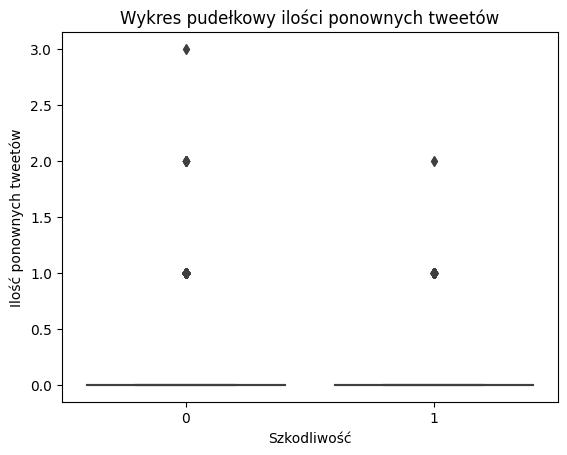

In [16]:
plot = sns.boxplot(y='n_of_retweets', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Szkodliwość', ylabel='Ilość ponownych tweetów', title='Wykres pudełkowy ilości ponownych tweetów')
plt.show()

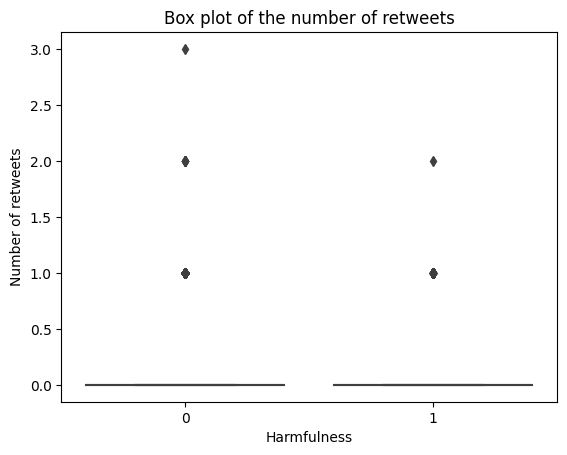

In [25]:
""" ENG """
plot = sns.boxplot(y='n_of_retweets', x='label', data=train)
update_seaborn_plot_labels_title(plot, xlabel='Harmfulness', ylabel='Number of retweets', title='Box plot of the number of retweets')
plt.show()

[ENG]: The box plot reinforces the conclusion obtained from the histogram. Only a higher number of outlier observations reaching the number 3 for benign tweets is visible.

[PL]: Wykres pudełkowy utwierdza we wniosku uzyskanym z histogramu. Widoczna jest jedynie większa ilość obserwacji odstających sięgająca liczby 3 dla tweetów nieszkodliwych.

## N-gram analysis

In [26]:
flat = [item for sublist in train[train.label == '0'].text_preprocessed.tolist() for item in sublist]
flat_harmful = [item for sublist in train[train.label == '1'].text_preprocessed.tolist() for item in sublist]

## Uni-grams

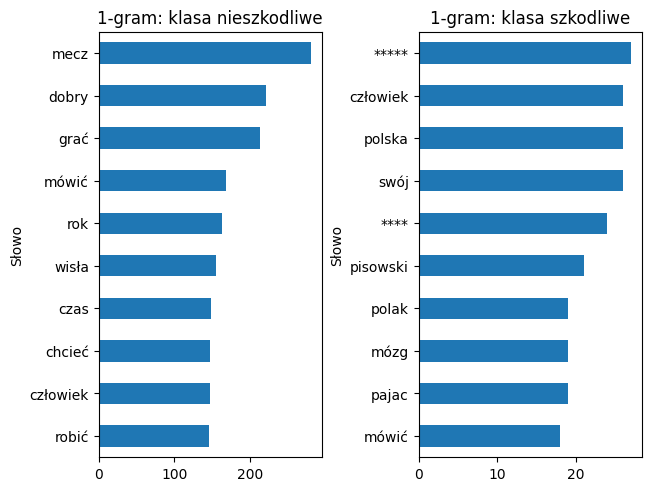

In [27]:
flat_harmful = [x.replace("kurwa", "*****").replace("dupa", "****") for x in flat_harmful]
plot_ngram(flat, flat_harmful, n=1, filter_words=['rt', 'mieć', 'być', 'wiedzieć', 'chyba', 'taki', 'móc'])

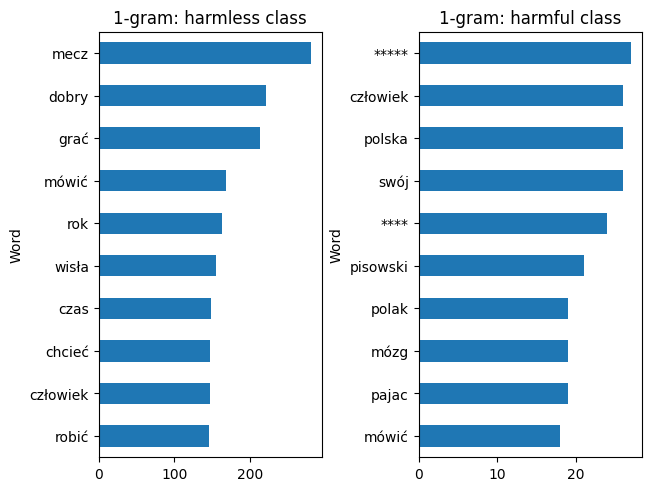

In [28]:
""" ENG """
plot_ngram(flat, flat_harmful, n=1, filter_words=['rt', 'mieć', 'być', 'wiedzieć', 'chyba', 'taki', 'móc'], lang='eng')

[ENG]: In the case of harmless texts, the most common words are 'match', 'good', 'play', 'year', 'vistas', 'time', 'want', 'do'. For harmful tweets, they are: vulgarisms (2x), 'polish', 'own', 'pisowski' (an adjective from the name of a political party), 'polak', 'brain', 'twit'. Common words are 'man', 'speak'. 

[PL]: W przypadku tekstów nieszkodliwych najczęściej występują słowa takie jak 'mecz', 'dobry', 'grać', 'rok', 'wisła', 'czas', 'chcieć', 'robić'. Dla tweetów szkodliwych są to: wulgaryzmy (2x), 'polska', 'swój', 'pisowski' (przymiotnik od nazwy partii politycznej), 'polak', 'mózg', 'pajac'. Wspólnymi wyrazami jest 'człowiek', 'mówić'. 

## Bi-grams

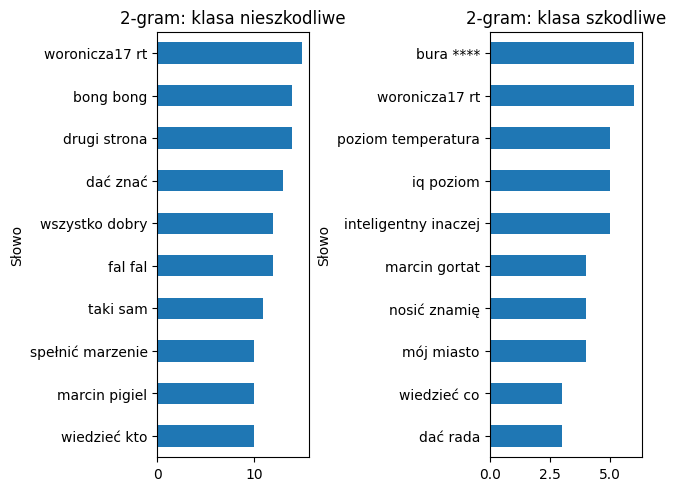

In [29]:
flat_harmful = [x.replace('suka', '****') for x in flat_harmful]
plot_ngram(flat, flat_harmful, n=2, filter_words=[''])

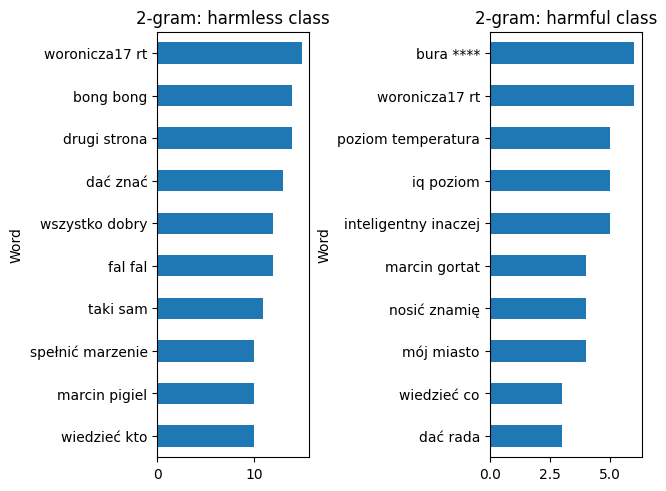

In [30]:
""" ENG """
plot_ngram(flat, flat_harmful, n=2, filter_words=[''], lang='eng')

[ENG]: The most common sequences of 2 words following each other for the harmless class are: 'bong bong', 'the other side', 'to let you know', 'all good', 'wave waves', 'same', 'fulfill a dream', 'marcin pigiel', 'know who'. For the pest class, these are: 'bura ****', 'temperature level', 'iq level', 'intelligent otherwise', 'marcin gortat', 'wear a birthmark', 'my city', 'know what', 'give advice'. The common part is 'woronicza17 rt', which is a reference to a television program broadcast on national television. 

[PL]: Najczęściej występujące sekwencje 2 wyrazów po sobie dla klasy nieszkodliwej to: 'bong bong', 'drugi strona', 'dać znać', 'wszystko dobry', 'fal fal', 'taki sam', 'spełnić marzenie', 'marcin pigiel', 'wiedzieć kto'. Dla klasy szkodliwej są to: 'bura ****', 'poziom temperatura', 'iq poziom', 'inteligentny inaczej', 'marcin gortat', 'nosić znamię', 'mój miasto', 'wiedzieć co', 'dać rada'. Częścią wspólną stanowi 'woronicza17 rt', który to odnosi się do programu telewizyjnego nadawanego w telewizji krajowej. 

## Tri-grams

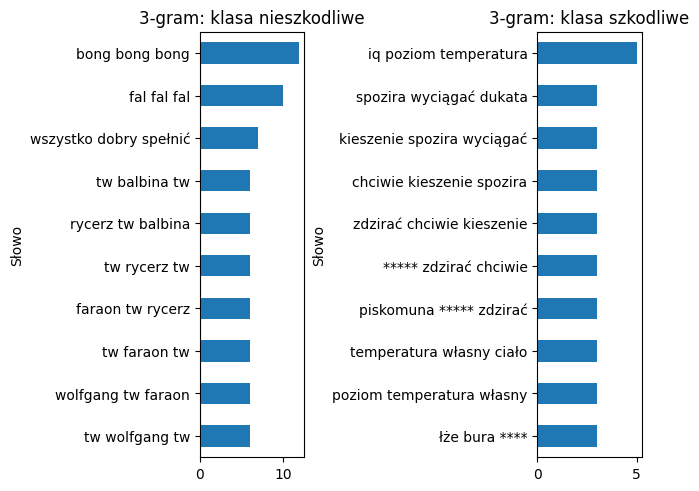

In [31]:
plot_ngram(flat, flat_harmful, n=3, filter_words=[])

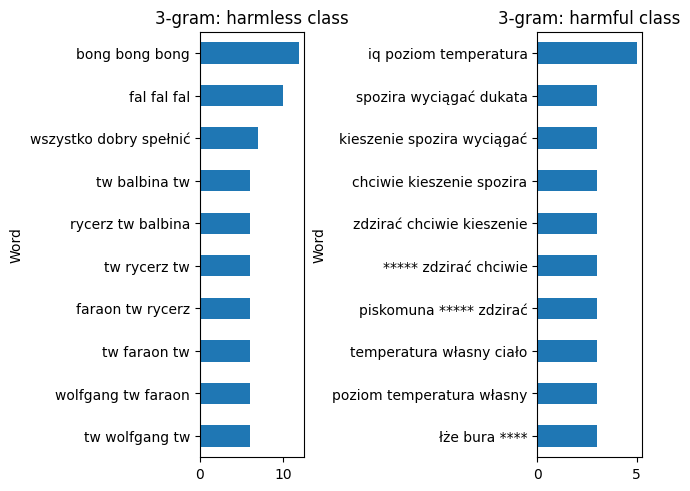

In [32]:
""" ENG """
plot_ngram(flat, flat_harmful, n=3, filter_words=[], lang='eng')

[ENG]: The most common consecutive sequences of 3 words in the neutral category are: 'bong bong bong', 'wave wave wave', 'all good meet', 'tw balbina tw', 'knight tw balbina', 'pharaoh tw knight', 'tw pharaoh tw', 'wolfgang tw pharaoh', 'tw wolfgang tw'. On the other hand, in the negative category are: 'iq level temperature', 'spozira pull out a ducat', 'spozira pockets pull out', 'greedy spozira pockets', 'rip off greedy pockets', '***** rip off greedy', 'squeakomuna *'.

The same sequences are no longer visible for trigrams. Neutral tweets can lead to a reference to the conduct of the case related to politics. In turn, the main slander has already appeared in tweets.

[PL]: Najczęściej występujące po sobie sekwencje 3 wyrazów w kategorii neutralnej stanowią: 'bong bong bong', 'fal fal fal', 'wszystko dobry spełnić', 'tw balbina tw', 'rycerz tw balbina', 'faraon tw rycerz', 'tw faraon tw', 'wolfgang tw faraon', 'tw wolfgang tw'. Z kolei w kategorii negatywnej są to: 'iq poziom temperatura', 'spozira wyciągać dukata', 'kieszenie spozira wyciągąć', 'chciwe kieszenie spozira', 'zdzirać chciwe kieszenie', '***** zdzirać chciwe', 'piskomuna ***** zdzirać', 'temperatura własny ciało', 'poziom temperatura własny', 'łże bura ****'. 

Dla tri-gramów już nie występują te same sekwencje. W tweetach neutralnych można zauważyć nawiązywanie do pewnych konkretnych tematów związanych z polityką. Z kolei w tweetach szkodliwych występują już głównie oszczerstwa. 